## Commuting Time dependent Hamiltonian

$$
\begin{equation}
    H(t) = J_{i}B^{i}
\end{equation}
$$
$$ 
    H(t) = J_{1}B^{1}\sin(\omega t)
$$
$$
\begin{equation}
    [H(t_1), H(t_2)] = 0 \;\forall\; t_1, t_2
\end{equation}
$$
$$
\begin{equation}
    U(t) = \text{exp}\left[-i J_1 B_1 \int_{0}^{t} dt' sin(\omega t')\right]
\end{equation}
$$

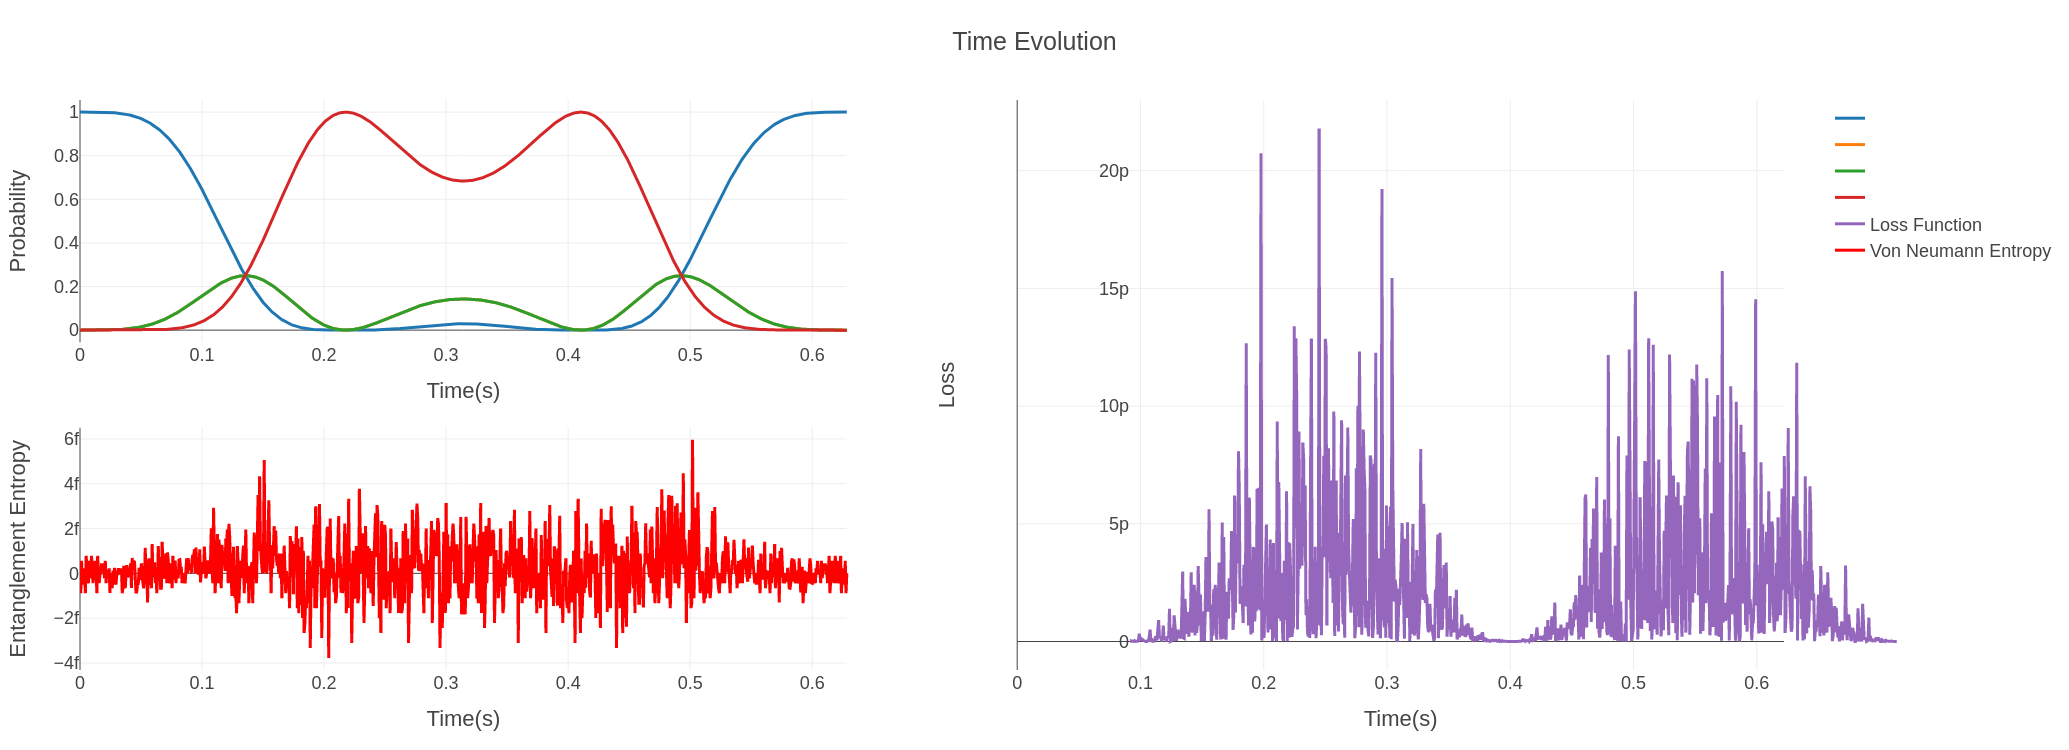

In [143]:
import torch as torch
from qunum import qunum as qn
from qunum.jupyter_tools.plotting import *
from itertools import product
setup_plotly()
S = qn.TQobj(qn.algebra.representations.su.get_pauli(to_tensor=True), n_particles = 1)
B = (1e1, 0, 0)
w = 10
Jx = (S[1]^S[0]) + (S[0]^S[1])
H0 = Jx*B[0]
t = torch.linspace(0, 2*torch.pi/w, 1000, requires_grad=True)
H = qn.einsum('A,ij->Aij', torch.sin(w*t), H0)
e1, e0 = qn.TQobj([[0],[1]], dtype = torch.complex128), qn.TQobj(torch.tensor([[1],[0]], dtype = torch.complex128))
p = (e0^e0)@ (e0^e0).dag()
U = (
    -1j*(
        qn.einsum('ij, A->Aij',H0, (1-torch.cos(w*t))/w)
    )
).expm() 

p = U.dag() @ p @ U

fig = plty_sub.make_subplots(rows=2,cols=2, specs=[[{},{'rowspan':2}],[{},{}]])
for i,j in enumerate((product(*[range(p._metadata.dims[d]) for d in p._metadata.dims]))):
    fig.add_trace(go.Scatter(y=p[:,i, i].detach().real, x = t.detach().real, name='$P_{\\left|'+str(j)+'\\right>}$'),row=1,col=1)
fig.update_xaxes(title = 'Time(s)', row=1,col=1)
fig.update_yaxes(title = 'Probability',row= 1, col=1)
fig.update_layout(title = 'Time Evolution', height = 750, width= 1500)

Loss = (1j*qn.Dx(U, t,0)-H@U)

Loss = (Loss.dag() @ Loss).real.sum(dim=(1,2))

fig.add_trace(go.Scatter(y = Loss.detach().numpy()[10:], x = t.detach().numpy(), name = 'Loss Function'), row = 1, col=2)
S = p.Tr(0).entropy().real

fig.add_trace(go.Scatter(y = S.detach() , x = t.detach(), line=dict(color='red'), name="Von Neumann Entropy"), col=1, row=2)
fig.update_xaxes(title = 'Time(s)', row=2,col=1)
fig.update_yaxes(title = 'Entanglement Entropy',row= 2, col=1)
fig.update_xaxes(title = 'Time(s)', row=1,col=2)
fig.update_yaxes(title = 'Loss',row= 1, col=2)
iplot(fig)